# Run Modelmu aja Jangan Semua

# Import Datas

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from google.colab import drive, files
from PIL import Image
import logging

# Download and unzip dataset
!kaggle datasets download -d alfanme/indonesian-batik-motifs-corak-app
!unzip indonesian-batik-motifs-corak-app.zip

# configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# preprocess.
from keras.preprocessing.image import ImageDataGenerator

# dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1, VGG16, Xception, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install efficientnet

from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.applications import DenseNet201


Dataset URL: https://www.kaggle.com/datasets/alfanme/indonesian-batik-motifs-corak-app
License(s): CC0-1.0
 99% 154M/156M [00:09<00:00, 22.7MB/s]
100% 156M/156M [00:09<00:00, 17.0MB/s]
Archive:  indonesian-batik-motifs-corak-app.zip
  inflating: DATASET/DATASET/TEST/Batik Bali/70.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/71.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/72.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/73.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/74.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/75.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/76.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/77.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/78.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/79.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/80.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/81.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/82.jpg  
  inflating: DATASET/DATASET/TEST/Batik Bali/83.jpg  
  inflating

# Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = './DATASET/DATASET/TRAIN'
test_path = './DATASET/DATASET/TEST'

def data_augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Random rotation
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    return image

# Data generators with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=data_augmentation,
    rescale=1./255  # Rescale images
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Rescale images for validation set

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=123,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    seed=123,
    shuffle=False
)


Found 1050 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


# Show Some Sample

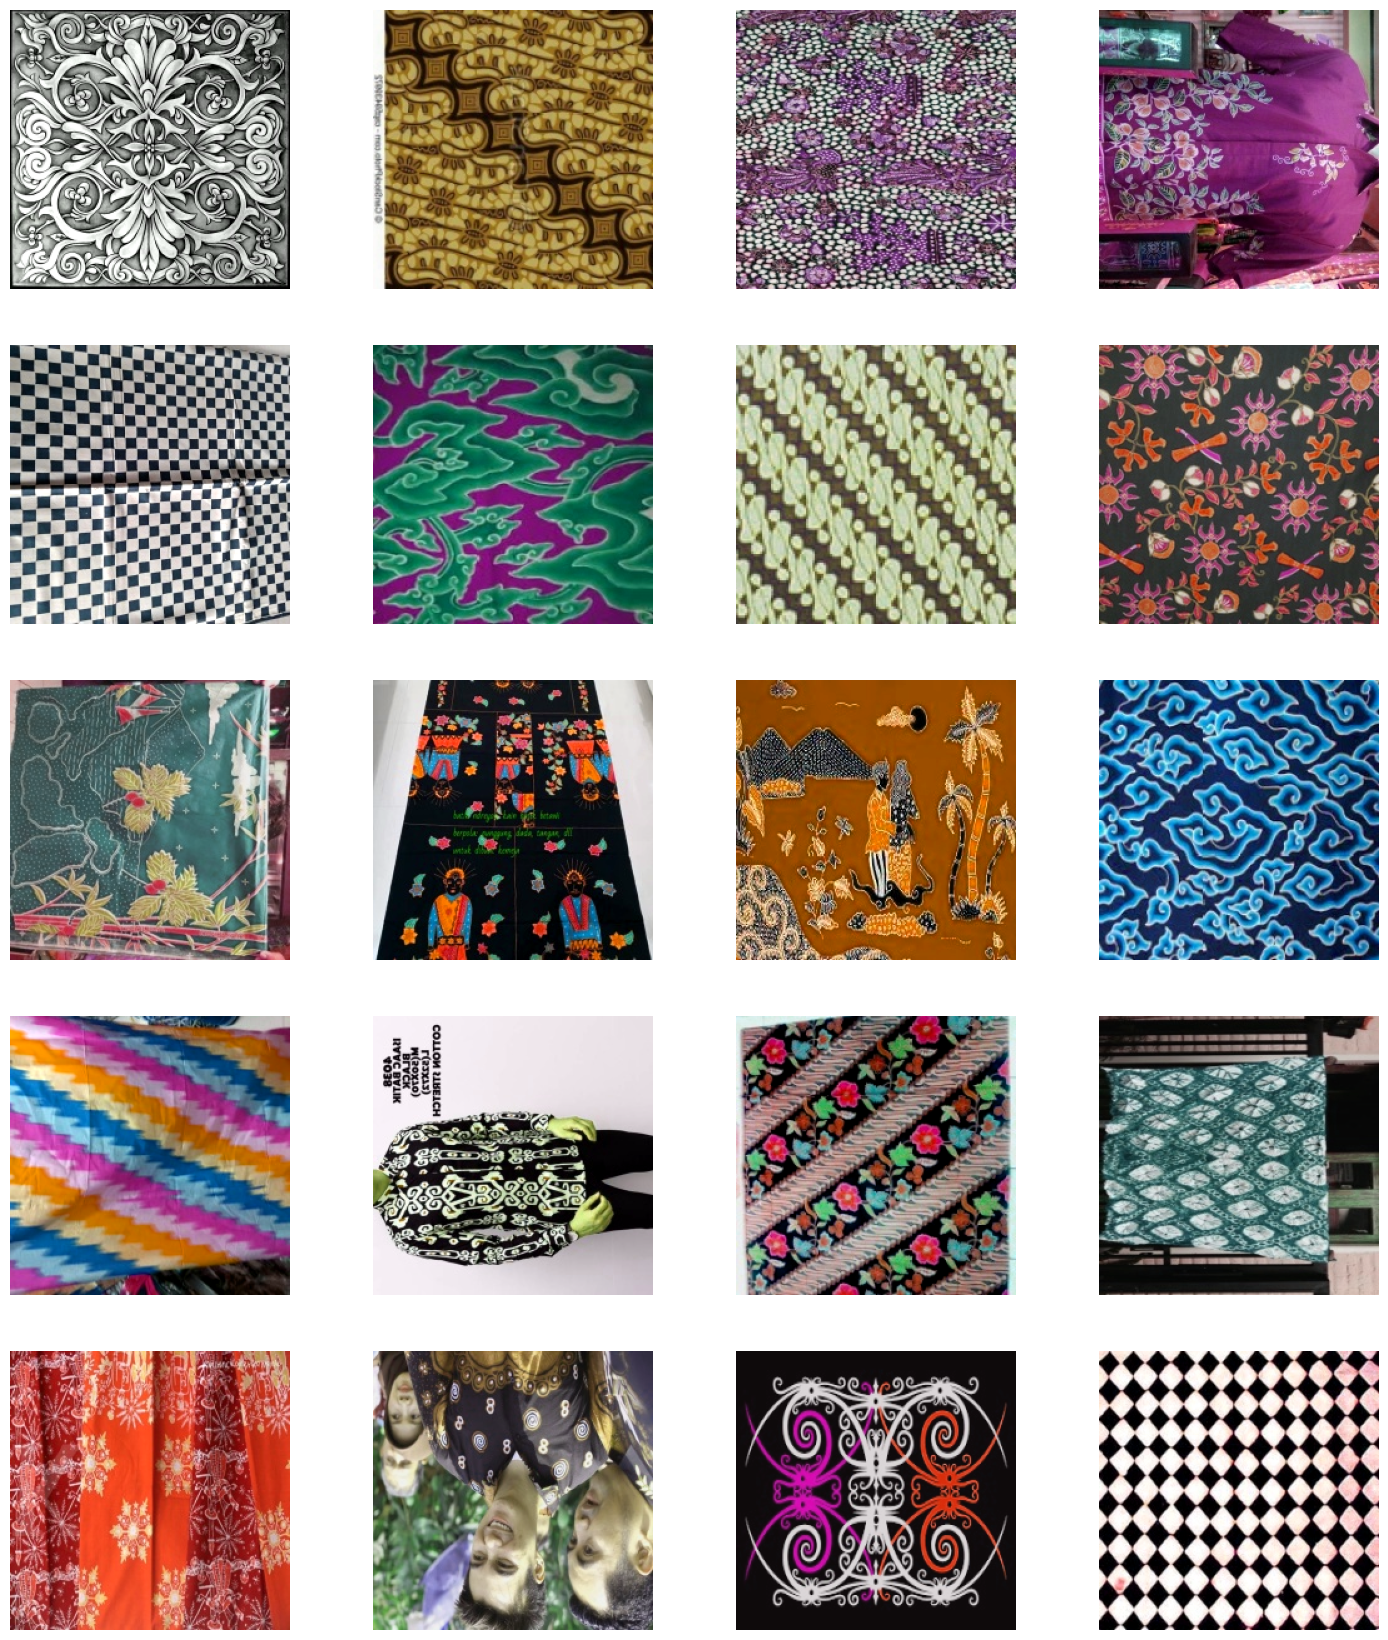

In [ ]:
plt.figure(figsize=(16, 20))

for i in range(20):
    img, label = train_generator.next()
    plt.subplot(5, 4, i+1)
    plt.imshow(img[0])
    plt.axis('off')

plt.show()

# Class Labelling

In [ ]:
motives_dict = train_generator.class_indices
print(motives_dict)

{'Batik Bali': 0, 'Batik Betawi': 1, 'Batik Cendrawasih': 2, 'Batik Dayak': 3, 'Batik Geblek Renteng': 4, 'Batik Ikat Celup': 5, 'Batik Insang': 6, 'Batik Kawung': 7, 'Batik Lasem': 8, 'Batik Megamendung': 9, 'Batik Pala': 10, 'Batik Parang': 11, 'Batik Poleng': 12, 'Batik Sekar Jagad': 13, 'Batik Tambal': 14}


# Efficientnet80

In [ ]:
from tensorflow.keras import regularizers
def unfreeze_model(model, layers_to_unfreeze):
    for layer in model.layers[-layers_to_unfreeze:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    return model

# Initial training with frozen base model
clear_session()

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)

base_model.trainable = False
model = Sequential([
    base_model,
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(15, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with frozen base
initial_epochs = 500
history_frozen = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    shuffle=True,
    epochs=initial_epochs,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/500
33/33 [==============================] - 20s 429ms/step - loss: 2.9319 - accuracy: 0.0695 - val_loss: 2.6918 - val_accuracy: 0.1167 - lr: 1.0000e-04
Epoch 2/500
33/33 [==============================] - 13s 395ms/step - loss: 2.7684 - accuracy: 0.0952 - val_loss: 2.6212 - val_accuracy: 0.1400 - lr: 1.0000e-04
Epoch 3/500
33/33 [==============================] - 15s 473ms/step - loss: 2.7001 - accuracy: 0.1133 - val_loss: 2.5636 - val_accuracy: 0.2033 - lr: 1.0000e-04
Epoch 4/500
33/33 [==============================] - 14s 424ms/step - loss: 2.6573 - accuracy: 0.1152 - val_loss: 2.5142 - val_accuracy: 0.2600 - lr: 1.0000e-04
Epoch 5/500
33/33 [==============================] - 13s 393ms/step - loss: 2.6124 - accuracy: 0.1419 - val_loss: 2.4696 - val_accuracy: 0.3067 - lr: 1.0000e-04
Epoch 6/500
33/33 [==============================] - 13s 391ms/step - loss: 2.5359 - accuracy: 0.1695 - val_loss: 2.4169 - val_accuracy: 0.3433 - lr: 1.0000e-04
Epoch 7/500
33/33 [===============

Epoch 1/200
17/17 [==============================] - 32s 922ms/step - loss: 2.7788 - accuracy: 0.0743 - val_loss: 2.6877 - val_accuracy: 0.1167 - lr: 1.0000e-04
Epoch 2/200
17/17 [==============================] - 7s 393ms/step - loss: 2.6608 - accuracy: 0.1190 - val_loss: 2.5971 - val_accuracy: 0.1533 - lr: 1.0000e-04
Epoch 3/200
17/17 [==============================] - 6s 367ms/step - loss: 2.5726 - accuracy: 0.1590 - val_loss: 2.5167 - val_accuracy: 0.2067 - lr: 1.0000e-04
Epoch 4/200
17/17 [==============================] - 7s 393ms/step - loss: 2.4836 - accuracy: 0.2219 - val_loss: 2.4399 - val_accuracy: 0.2533 - lr: 1.0000e-04
Epoch 5/200
17/17 [==============================] - 6s 369ms/step - loss: 2.4156 - accuracy: 0.2610 - val_loss: 2.3585 - val_accuracy: 0.3000 - lr: 1.0000e-04
Epoch 6/200
17/17 [==============================] - 7s 400ms/step - loss: 2.3312 - accuracy: 0.2905 - val_loss: 2.2741 - val_accuracy: 0.3567 - lr: 1.0000e-04
Epoch 7/200
17/17 [====================

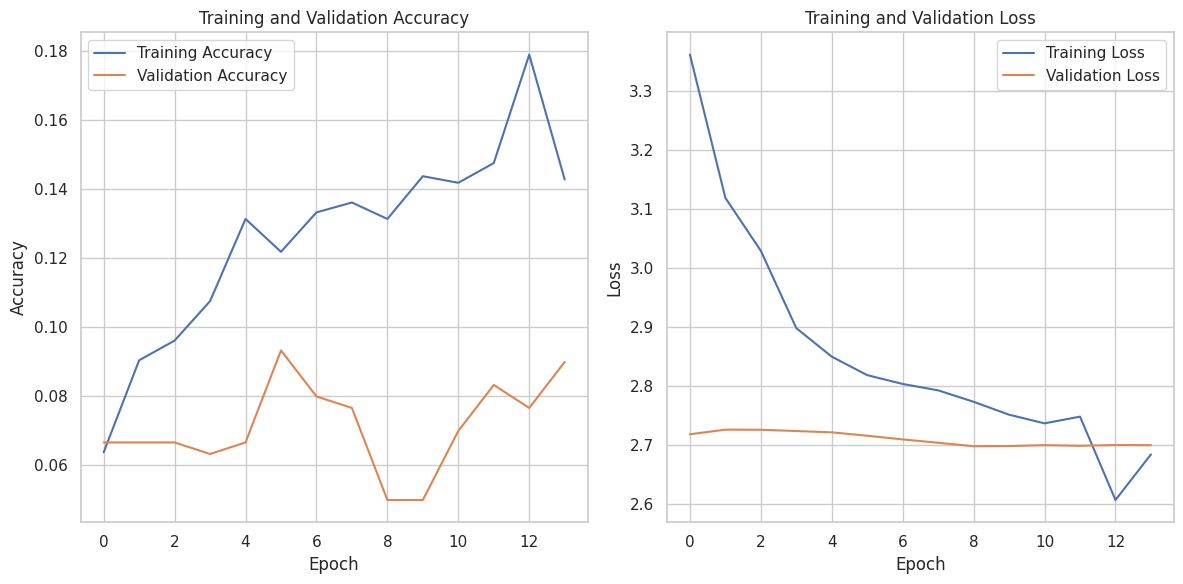

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_eff.history['accuracy'], label='Training Accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_eff.history['loss'], label='Training Loss')
plt.plot(history_eff.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Model VGG16 (Bagus Yg LAma Belum Kuganti)

In [ ]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Clear any previous models from memory
from tensorflow.keras.backend import clear_session
clear_session()

# Build your model with updated regularization and BatchNormalization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.6),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(15, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Print the model summary
model.summary()

# Define callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with early stopping and reducing learning rate
history_vgg = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    shuffle=True,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                         

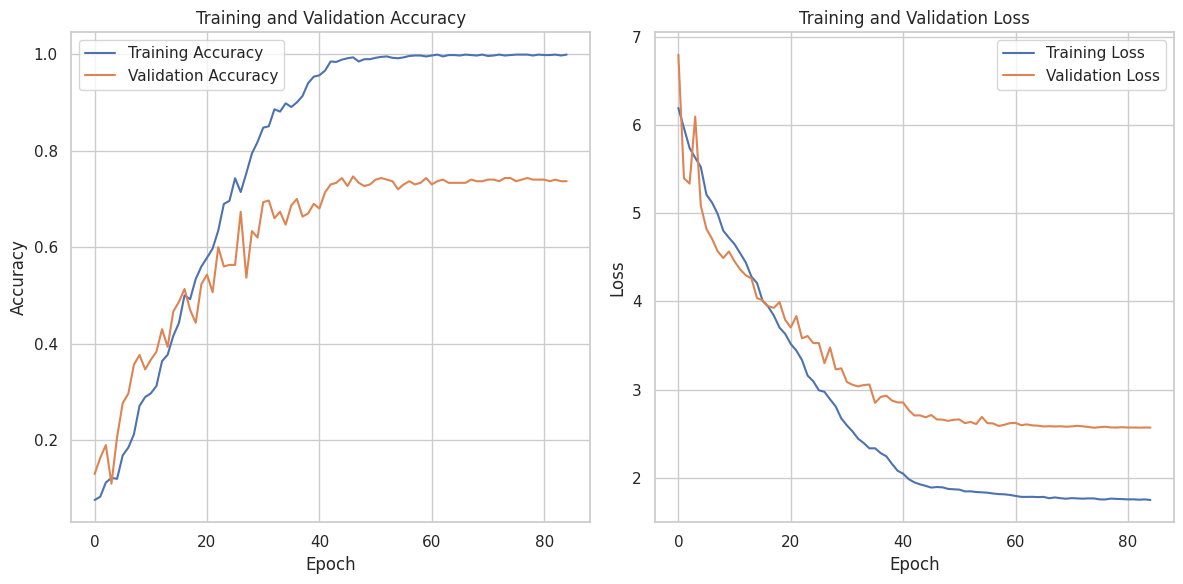

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Training Loss')
plt.plot(history_vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Efficientnet80 using Gradual Unfreezing Fine Tuning (Dabest So far)

In [ ]:
from tensorflow.keras import regularizers
def unfreeze_model(model, layers_to_unfreeze):
    for layer in model.layers[-layers_to_unfreeze:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    return model

# Initial training with frozen base model
clear_session()

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)

base_model.trainable = False
model = Sequential([
    base_model,
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with frozen base
initial_epochs = 200
history_frozen = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    shuffle=True,
    epochs=initial_epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Gradually unfreeze and retrain
layers_to_unfreeze = 30  # Adjust based on experimentation
model = unfreeze_model(model, layers_to_unfreeze)
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with unfrozen layers
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    shuffle=True,
    epochs=initial_epochs + 100,
    initial_epoch=initial_epochs,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200
33/33 [==============================] - 20s 408ms/step - loss: 2.7543 - accuracy: 0.0714 - val_loss: 2.6464 - val_accuracy: 0.1400 - lr: 1.0000e-04
Epoch 2/200
33/33 [==============================] - 13s 388ms/step - loss: 2.6563 - accuracy: 0.1162 - val_loss: 2.5634 - val_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 3/200
33/33 [==============================] - 12s 372ms/step - loss: 2.5911 - accuracy: 0.1410 - val_loss: 2.4881 - val_accuracy: 0.2333 - lr: 1.0000e-04
Epoch 4/200
33/33 [==============================] - 12s 374ms/step - loss: 2.4968 - accuracy: 0.1695 - val_loss: 2.4051 - val_accuracy: 0.2533 - lr: 1.0000e-04
Epoch 5/200
33/33 [==============================] - 12s 368ms/step - loss: 2.4400 - accuracy: 0.2019 - val_loss: 2.3214 - val_accuracy: 0.3067 - lr: 1.0000e-04
Epoch 6/200
33/33 [==============================] - 14s 416ms/step - loss: 2.3493 - accuracy: 0.2581 - val_loss: 2.2389 - val_accuracy: 0.3700 - lr: 1.0000e-04
Epoch 7/200
33/33 [===============

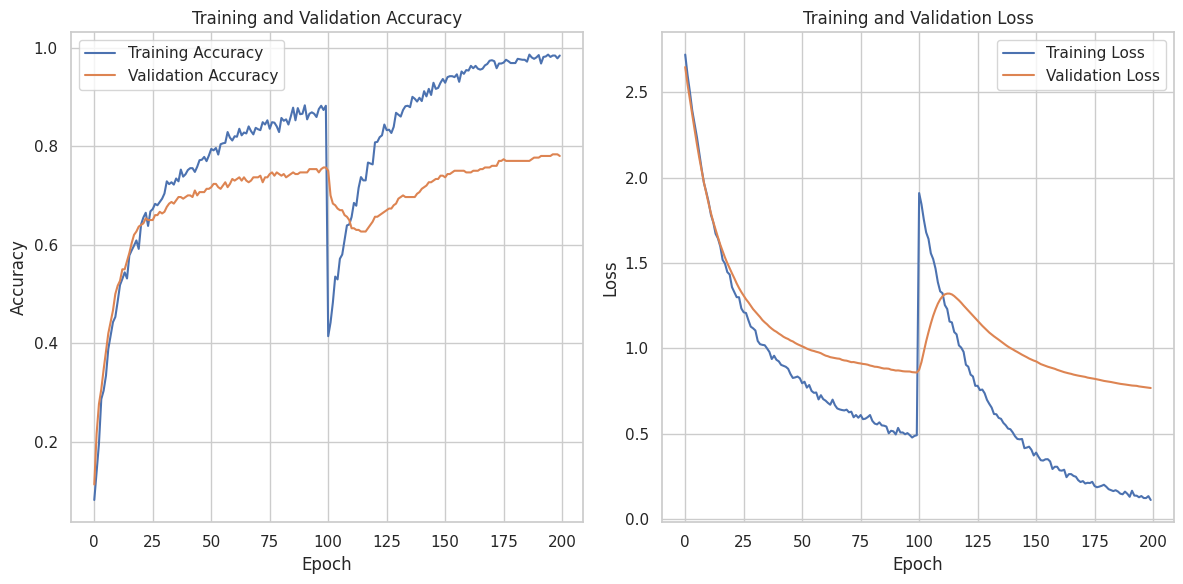

In [ ]:
# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_frozen.history['accuracy'] + history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_frozen.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_frozen.history['loss'] + history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_frozen.history['val_loss'] + history_fine_tune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

#



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load the DenseNet201 model with pre-trained weights
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Initial dropout rate of 0.5
x = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
x = Dropout(0.5)(x)  # Initial dropout rate of 0.5
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[reduce_lr, early_stopping]
)

# If validation loss is still high, increase dropout to 0.7 and retrain
if history.history['val_loss'][-1] > 0.5:  # Adjust the threshold as needed
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)  # Increased dropout rate to 0.7
    x = Dense(1024, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)
    x = Dropout(0.7)(x)  # Increased dropout rate to 0.7
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(
        train_data,
        epochs=50,
        validation_data=val_data,
        callbacks=[reduce_lr, early_stopping]
    )


74836368/74836368 [==============================] - 4s 0us/step


NameError: name 'train_data' is not defined

In [ ]:
# Train the model with frozen base
initial_epochs = 300
history_frozen = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    shuffle=True,
    epochs=initial_epochs,
    callbacks=callbacks
)

def plot_training_history(history, steps):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(steps)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Plot the initial training history
plot_training_history(history_frozen, initial_epochs)

In [ ]:
def fine_tune_model(model, initial_epochs, additional_epochs, layers_to_unfreeze):
    model = unfreeze_model(model, layers_to_unfreeze)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    history_fine_tune = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        shuffle=True,
        epochs=initial_epochs + additional_epochs,
        initial_epoch=initial_epochs,
        callbacks=callbacks
    )
    return history_fine_tune

# Fine-tuning in steps
fine_tune_epochs = 200

history_fine_tune_1 = fine_tune_model(model, initial_epochs, fine_tune_epochs, layers_to_unfreeze=10)
plot_training_history(history_fine_tune_1, initial_epochs + fine_tune_epochs)

history_fine_tune_2 = fine_tune_model(model, initial_epochs + fine_tune_epochs, fine_tune_epochs, layers_to_unfreeze=20)
plot_training_history(history_fine_tune_2, initial_epochs + 2*fine_tune_epochs)

history_fine_tune_3 = fine_tune_model(model, initial_epochs + 2*fine_tune_epochs, fine_tune_epochs, layers_to_unfreeze=30)
plot_training_history(history_fine_tune_3, initial_epochs + 3*fine_tune_epochs)

In [ ]:
# Combine history data
def combine_histories(history_frozen, *fine_tune_histories):
    combined_history = {}
    for key in history_frozen.history.keys():
        combined_history[key] = history_frozen.history[key]
        for fine_tune_history in fine_tune_histories:
            combined_history[key] += fine_tune_history.history[key]
    return combined_history

combined_history = combine_histories(history_frozen, history_fine_tune_1, history_fine_tune_2, history_fine_tune_3)

# Plot the combined history
class CombinedHistory:
    def __init__(self, combined_history):
        self.history = combined_history

combined_history_obj = CombinedHistory(combined_history)
plot_training_history(combined_history_obj, initial_epochs + 3*fine_tune_epochs)


xception

In [ ]:
# Data augmentation
data_augmentation = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])


16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/500
33/33 [==============================] - 31s 546ms/step - loss: 4.1706 - accuracy: 0.0552 - val_loss: 3.8786 - val_accuracy: 0.1233 - lr: 1.0000e-04
Epoch 2/500
33/33 [==============================] - 13s 389ms/step - loss: 3.9290 - accuracy: 0.1029 - val_loss: 3.7776 - val_accuracy: 0.2067 - lr: 1.0000e-04
Epoch 3/500
33/33 [==============================] - 12s 377ms/step - loss: 3.8379 - accuracy: 0.1190 - val_loss: 3.6991 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 4/500
33/33 [==============================] - 13s 407ms/step - loss: 3.7615 - accuracy: 0.1305 - val_loss: 3.6271 - val_accuracy: 0.3033 - lr: 1.0000e-04
Epoch 5/500
33/33 [==============================] - 12s 375ms/step - loss: 3.6629 - accuracy: 0.1533 - val_loss: 3.5561 - val_accuracy: 0.3533 - lr: 1.0000e-04
Epoch 6/500
33/33 [==============================] - 12s 369ms/step - loss: 3.6293 - accuracy: 0.1743 - val_loss: 3.4829 - val_acc

TypeError: object of type 'method' has no len()

# MobilenetV2 (Overfit Paling Mending)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

clear_session()

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Number of classes (adjust this according to your dataset)
num_classes = 15

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    train_generator,
    epochs=300,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)


In [ ]:
import matplotlib.pyplot as plt

def plot(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function with your model's training history
plot(history)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

# Clear previous session
#clear_session()

# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Number of classes (adjust this according to your dataset)
num_classes = 15

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Reduced dropout rate
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Reduced dropout rate
predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Reduced patience

# Training the model with frozen base model
history = model.fit(
    train_generator,
    epochs=500,  # Reduced epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Further training with fine-tuning
history_fine = model.fit(
    train_generator,
    epochs=250,  # Reduced epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

9406464/9406464 [==============================] - 1s 0us/step


NameError: name 'train_generator' is not defined

In [ ]:
# Plotting function
def plot(history, history_fine):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'] + history_fine.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot function with your model's training history
plot(history, history_fine)